# Vision Trials

This notebooks contains code to use pure computer vision algorithms without deep learning to classify thermal images

In [11]:
import cv2 as cv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from helpers import ensure_bgr, make_red_mask_hsv, detect_legend_mask, remove_small_components, shorten_path, view_misclassified_images, classify_folder

## Rule-based thermal hotspot detection (legend-aware)

We detect high-temperature spots (red) in HSV while masking legend areas (color bars) anywhere in the image.
- Build a red mask in HSV (two ranges due to hue wraparound).
- Detect legend regions via high-saturation elongated rectangles (vertical/horizontal) with multi-hue progression; search across the whole image.
- Remove legend from the red mask, clean small blobs, and classify as Faulty if a significant hotspot remains away from edges.

Tune thresholds if colormap differs (e.g., saturation/value cutoffs, elongation factors, or hue-bin checks).

In [12]:
def classify_thermal_image_cv(image_path, debug=False):
    """
    Legend-aware rule-based classifier: returns 'Faulty' if a significant hotspot remains
    after removing likely legend areas; else 'Normal'.
    args:
        image_path: Path to the input image file (string or Path).
        debug: If True, returns additional debug information.
    returns:
        'Faulty' or 'Normal' label (string). If debug=True, also returns
    """
    img = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read {image_path}")
    img = ensure_bgr(img)
    h, w = img.shape[:2]

    red_mask = make_red_mask_hsv(img)
    legend_mask = detect_legend_mask(img)
    red_mask_nolegend = cv.bitwise_and(red_mask, cv.bitwise_not(legend_mask))
    dil_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    red_mask_nolegend = cv.dilate(red_mask_nolegend, dil_kernel, iterations=1)
    red_mask_nolegend = cv.morphologyEx(red_mask_nolegend, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)), iterations=1)
    red_mask_nolegend = remove_small_components(red_mask_nolegend, min_area=max(5, int(0.002 * h * w)))

    contours, _ = cv.findContours(red_mask_nolegend, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    faulty = False
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < max(5, 0.0002 * h * w):
            continue
        x, y, ww, hh = cv.boundingRect(cnt)
        if hh / max(1, ww) > 6 and ww < 0.1 * w:
            continue
        M = cv.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        if cx < 0.02 * w or cx > 0.98 * w or cy < 0.02 * h or cy > 0.98 * h:
            continue
        faulty = True
        break

    label = "Faulty" if faulty else "Normal"
    if debug:
        overlay = img.copy()
        cv.drawContours(overlay, contours, -1, (0, 255, 0), 2)
        vis = cv.addWeighted(overlay, 0.7, cv.cvtColor(red_mask_nolegend, cv.COLOR_GRAY2BGR), 0.3, 0)
        return label, red_mask, legend_mask, red_mask_nolegend, vis
    return label

In [13]:
# Legend-aware classifier results using helpers.classify_folder
results_faulty = classify_folder('separated_data/faulty/*.*', classifier=classify_thermal_image_cv)
results_normal = classify_folder('separated_data/normal/*.*', classifier=classify_thermal_image_cv)
print(f"Legend-aware: Faulty correct: {results_faulty['Faulty']} / {results_faulty['Total']}")
print(f"Legend-aware: Normal correct: {results_normal['Normal']} / {results_normal['Total']}")

Legend-aware: Faulty correct: 41 / 69
Legend-aware: Normal correct: 36 / 36


Total images: 69 | Misclassified: 28


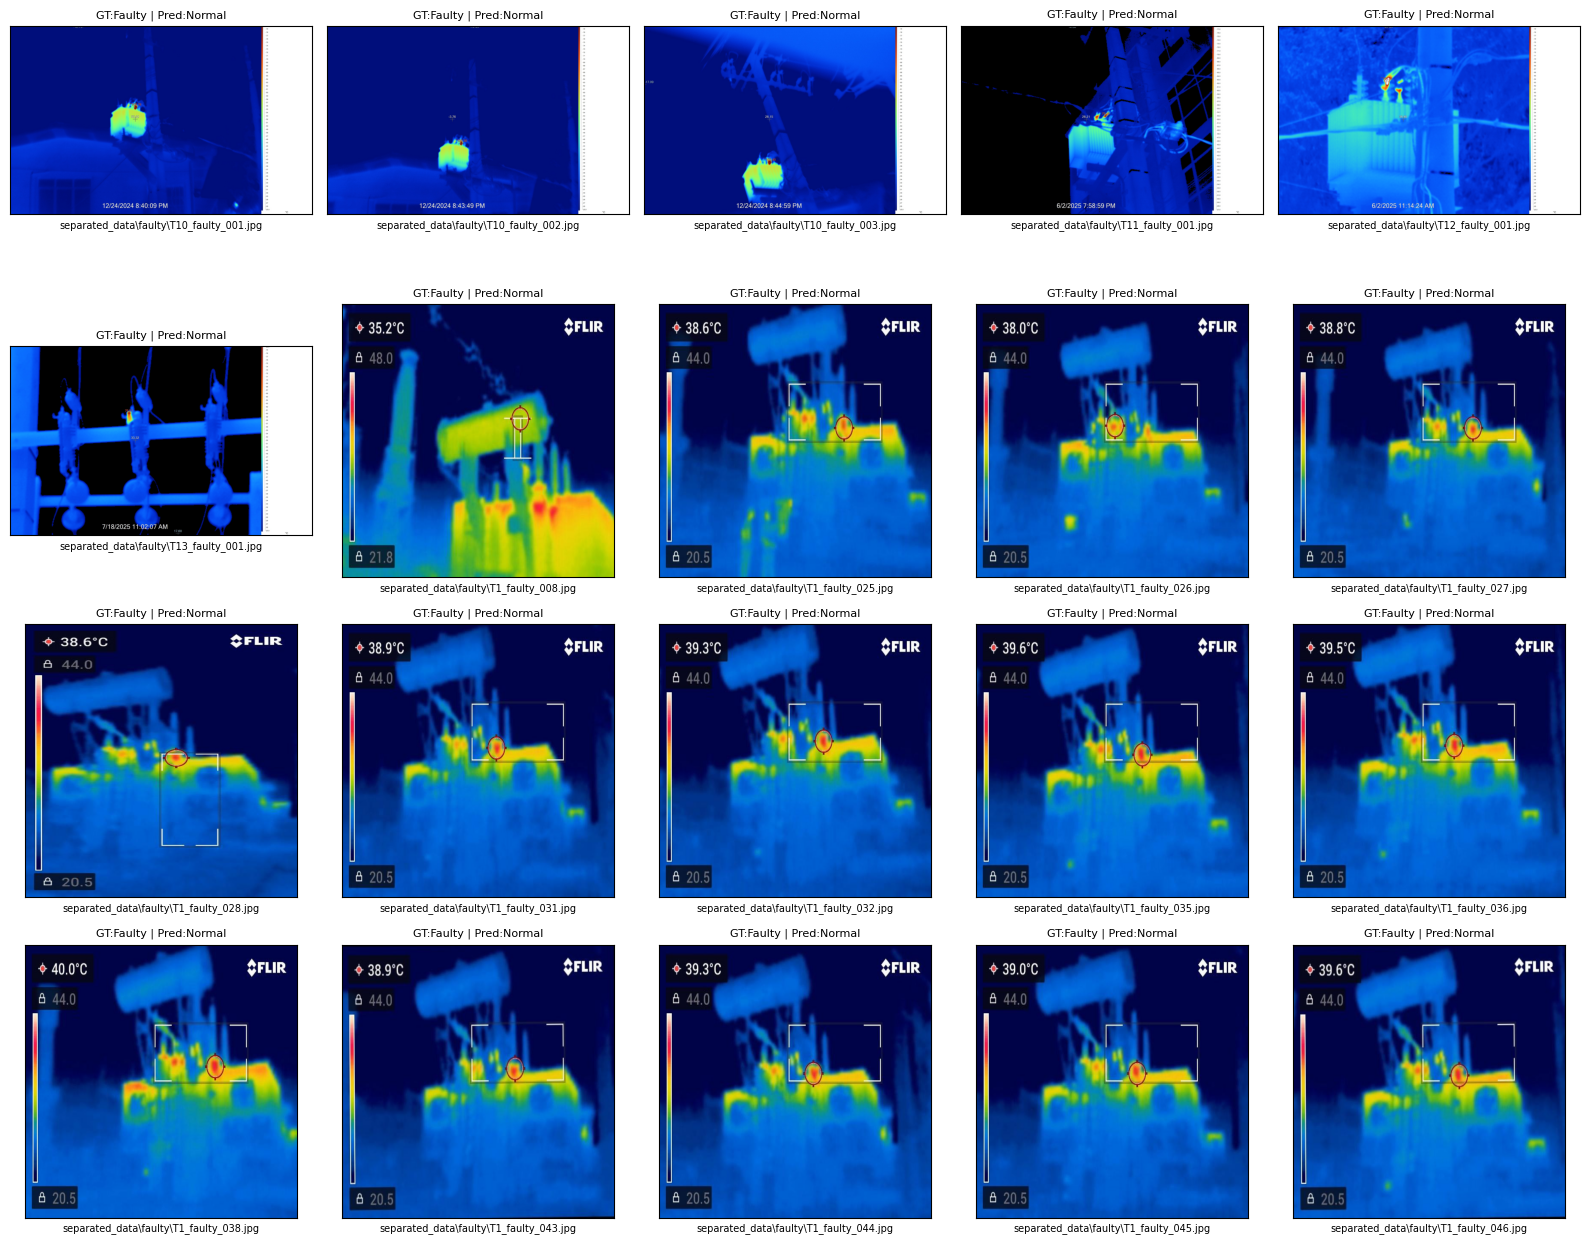

In [14]:
view_misclassified_images(results=results_faulty, expected_label="Faulty")

In [15]:
view_misclassified_images(results=results_normal, expected_label="Normal")

Total images: 36 | Misclassified: 0
No misclassifications.


View detected red parts

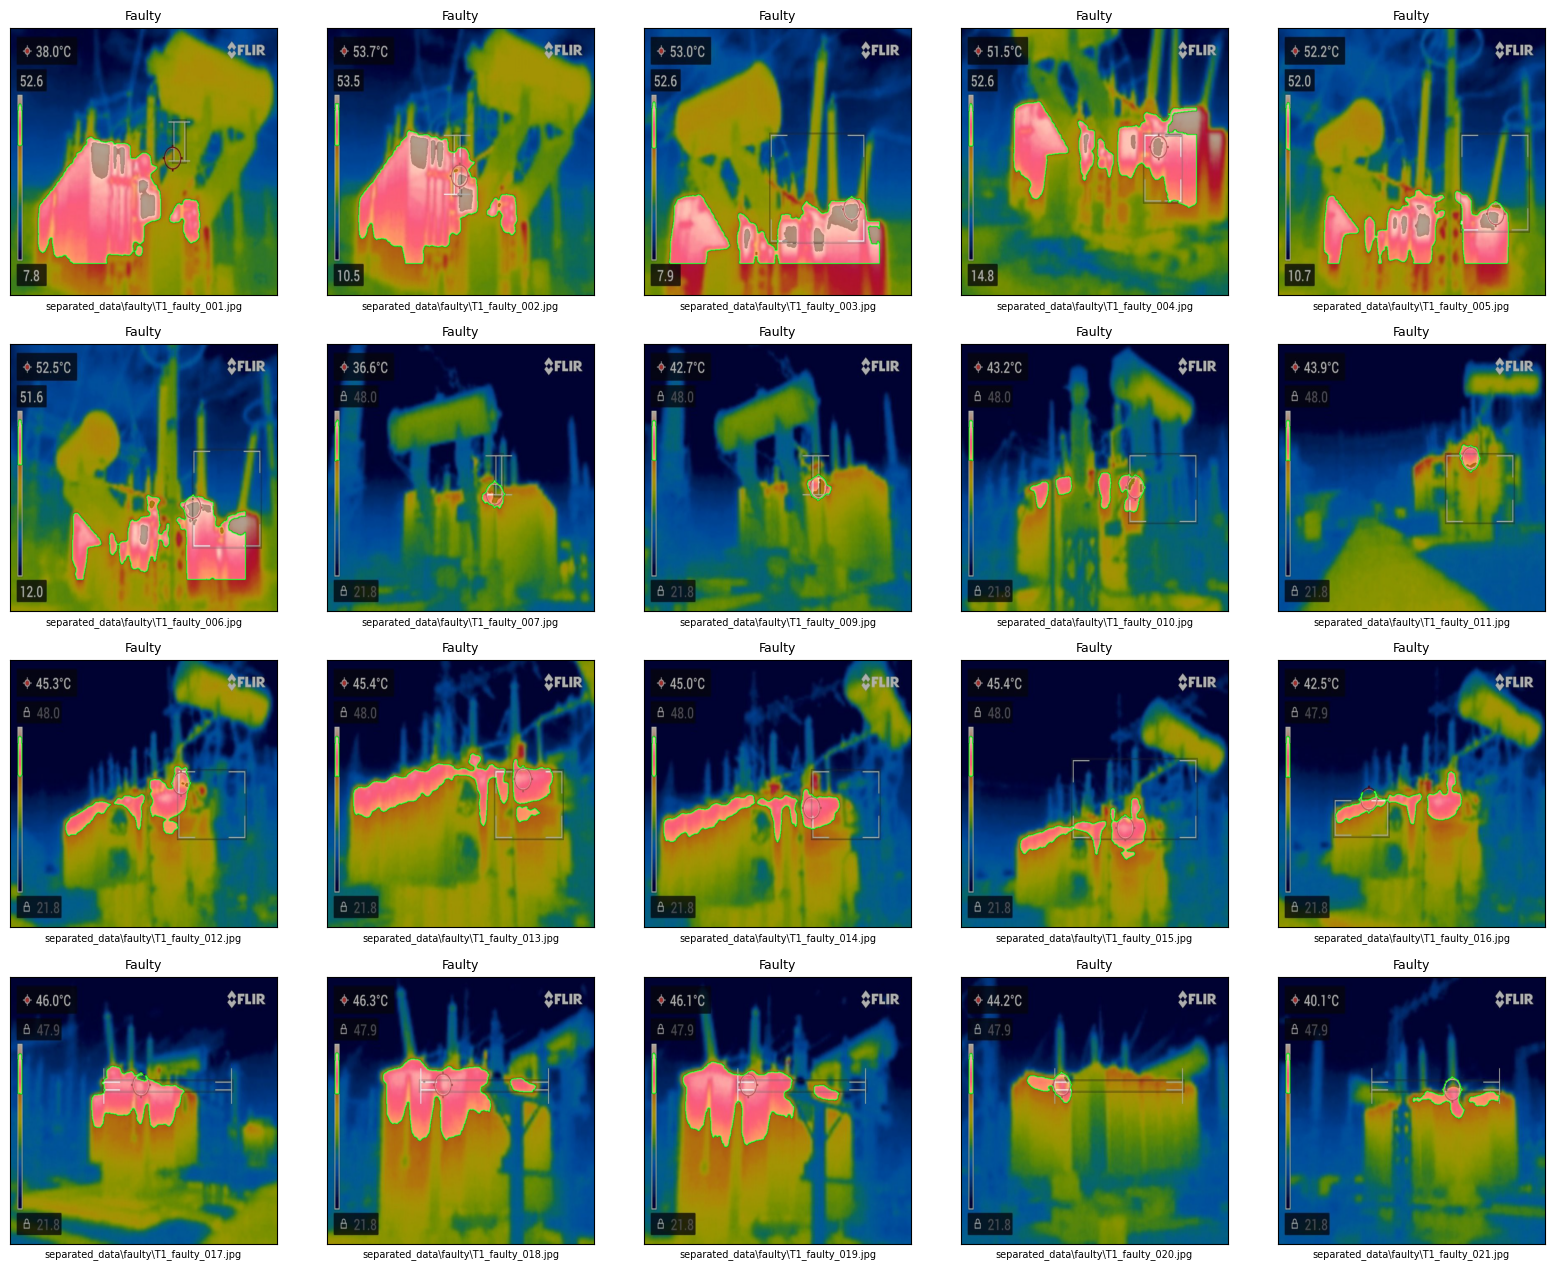

In [16]:
faulty_paths = sorted([str(p) for p in Path('separated_data/faulty').glob('*.*')])
target = 20
selected = [] 

for p in faulty_paths:
    try:
        label, red_mask, legend_mask, red_mask_nolegend, vis = classify_thermal_image_cv(p, debug=True)
        if label == "Faulty":
            vis_rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
            selected.append((p, label, vis_rgb))
            if len(selected) == target:
                break
    except Exception as e:
        pass

N = len(selected)
if N == 0:
    print("No images predicted as 'Faulty' to display.")
else:
    cols = 5
    rows = (min(target, N) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))
    if rows * cols == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    for j in range(rows * cols):
        ax = axes[j]
        if j < N:
            p, label, vis_rgb = selected[j]
            ax.imshow(vis_rgb)
            ax.set_title(label, fontsize=9)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_xlabel(shorten_path(p), fontsize=7)
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Central 80% red-only hotspot detection (no legend removal)
This section tests a simplified heuristic:
- Ignore left/right 10% columns (to avoid legends).
- Build red mask (reuse make_red_mask_hsv).
- Evaluate only central 80% region for hotspot presence (area threshold + optional dilation).
- Classify as Faulty if red area fraction exceeds a small threshold or any blob exceeds a pixel count.
You can tune: min_blob_area, min_total_fraction.

In [17]:
def classify_red_center(image_path, min_blob_area=250, min_total_fraction=0.001, debug=False):
    """Classify image using only red detection in central 80% (exclude left/right 10%).
    Args:
        image_path: path to image.
        min_blob_area: minimum area (pixels) for an individual blob to trigger Faulty.
        min_total_fraction: minimum fraction of central region covered by red to trigger Faulty.
        debug: return intermediate artifacts.
    Returns:
        label ('Faulty' | 'Normal') or tuple if debug.
    """
    img = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(image_path)
    img_bgr = ensure_bgr(img)
    h, w = img_bgr.shape[:2]
    red_mask = make_red_mask_hsv(img_bgr)
    left_cut = int(0.10 * w)
    right_cut = int(0.90 * w)
    central_mask = np.zeros_like(red_mask)
    central_mask[:, left_cut:right_cut] = 255
    red_central = cv.bitwise_and(red_mask, central_mask)
    dil = cv.dilate(red_central, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3)), iterations=1)
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(dil, connectivity=8)
    total_red = int(np.count_nonzero(dil))
    central_area = (right_cut - left_cut) * h
    red_fraction = total_red / max(1, central_area)
    faulty = False
    if red_fraction >= min_total_fraction:
        faulty = True
    else:
        for i in range(1, num_labels):
            area = stats[i, cv.CC_STAT_AREA]
            if area >= min_blob_area:
                faulty = True
                break
    label = 'Faulty' if faulty else 'Normal'
    if debug:
        overlay = img_bgr.copy()
        overlay[dil>0] = (0,0,255)
        vis = cv.addWeighted(overlay, 0.5, img_bgr, 0.5, 0)
        return label, red_mask, red_central, dil, vis
    return label

In [18]:
red_center_classifier = lambda p: classify_red_center(p, debug=False)
results_faulty_center = classify_folder('separated_data/faulty/*.*', classifier=red_center_classifier)
results_normal_center = classify_folder('separated_data/normal/*.*', classifier=red_center_classifier)
print(f"Center method - Faulty correct: {results_faulty_center['Faulty']} / {results_faulty_center['Total']}")
print(f"Center method - Normal correct: {results_normal_center['Normal']} / {results_normal_center['Total']}")

Center method - Faulty correct: 69 / 69
Center method - Normal correct: 8 / 36


In [19]:
view_misclassified_images(results=results_faulty_center, expected_label="Faulty")

Total images: 69 | Misclassified: 0
No misclassifications.


Total images: 36 | Misclassified: 28


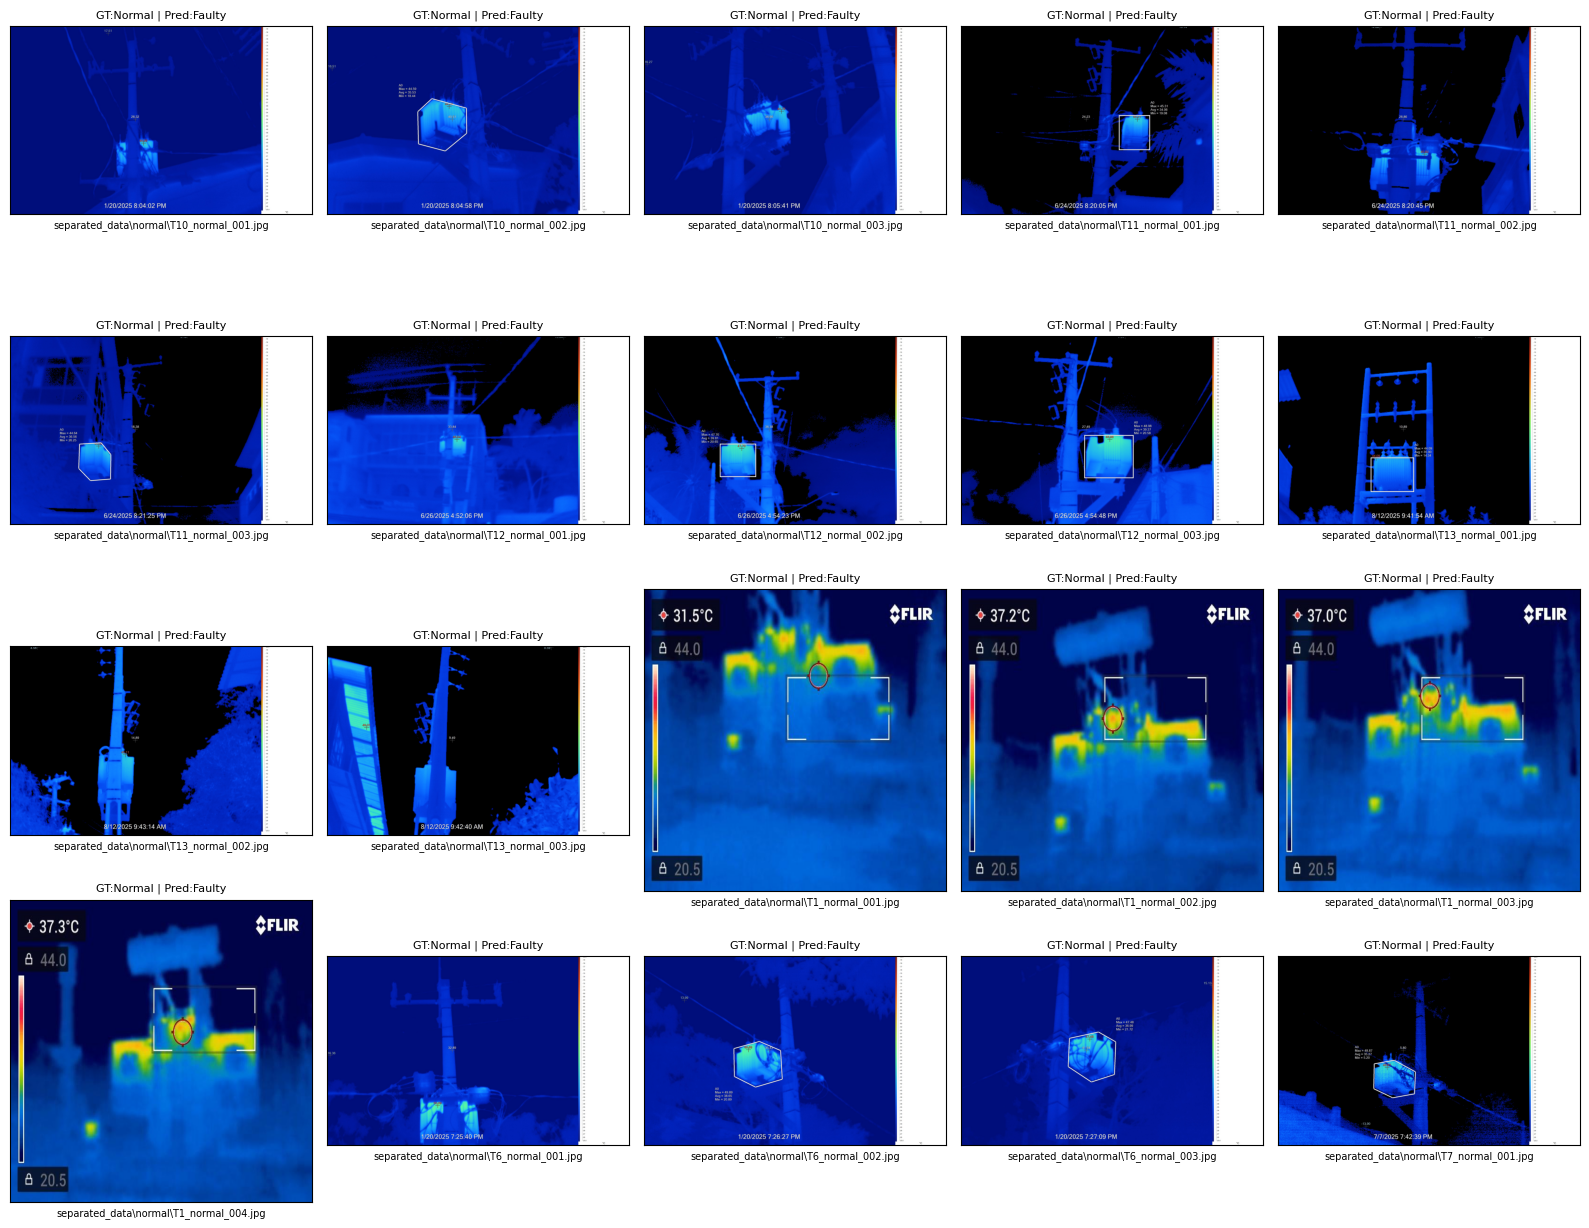

In [20]:
view_misclassified_images(results=results_normal_center, expected_label="Normal")